In [1]:
import json
import random
import numpy as np
import math
import datetime
from collections import Counter
import matplotlib as pyplot

# Scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Tensorflow and keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# plot training history
import matplotlib.pyplot as plt

In [2]:
K.clear_session()
tf.compat.v1.reset_default_graph()

In [3]:
def data():
    maxlen = 50
    embedding_size = 50
    pca_embedding_dim = 16
    
    # importing the glove embeddings path 
    embeddings_path = '../data/glove.6B.50d-char.txt'
    
    # Indexing character vectors using glove word vectors
    embedding_vectors = {}
    with open(embeddings_path, 'r') as f:
        for line in f:
            line_split = line.strip().split(" ")
            vec = np.array(line_split[1:], dtype=float)
            char = line_split[0]
            embedding_vectors[char] = vec
#     print('Found %s char vectors.' % len(embedding_vectors))
    
    # loading the dataset
    with open('../data/dataset.json', 'r') as f:
        dataset = json.load(f)
        positives = dataset['positives']
        negatives = dataset['negatives']
    
    # dividing the dataset to make small models
    data_fraction = 1
    positives = positives[:int(data_fraction * len(positives))]
    negatives = negatives[:int(data_fraction * len(negatives))]
    print("Total Dataset: ", len(positives+negatives))
    
    # Dividing the negatives dataset between train, dev and test
    negatives_train = negatives[0: int(len(negatives) * .8)]
    negatives_dev = negatives[int(len(negatives) * .8): int(len(negatives) * .9)]
    negatives_test = negatives[int(len(negatives) * .9): ]
    print("Split sizes:")
    print(len(positives), len(negatives_train), len(negatives_dev), len(negatives_test))
    
    # Shuffling the data
    a = [(i, 0) for i in negatives_train]
    b = [(i, 1) for i in positives]
    combined = a + b
    random.shuffle(combined)
    shuffled = list(zip(*combined))
    text_X = shuffled[0]
    labels = shuffled[1]
    
    # tokenizing the input url's
    tk = keras.preprocessing.text.Tokenizer(char_level=True)
    tk.fit_on_texts(text_X)
    
    # List the vocabulary
    word_index = tk.word_index
    vocab_size = len(word_index) + 1
#     print(vocab_size)
#     print(word_index)
    
    # integer encode the documents
    sequences = tk.texts_to_sequences(text_X)

    # pad documents to a max length of 4 words
    data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen) # by default the padding is post.
    labels = np.asarray(labels)
#     print('Shape of data tensor:', data.shape)
#     print('Shape of label tensor:', labels.shape)
    
    # Dividing the dataset into train and test.
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    # split the training data into a training set and a validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    print(len(X_train))
    print(len(X_val))
    
    # create a weight matrix for words in training docs
#     print('Preparing embedding matrix.')
    embedding_matrix = np.zeros((vocab_size, embedding_size))
    for char, i in word_index.items():
        embedding_vector = embedding_vectors.get(char)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
#     print(embedding_matrix.shape)
    
    # PCA Embedding dimension
    pca = PCA(n_components = pca_embedding_dim)
    pca.fit(embedding_matrix[1:])
    embedding_matrix_pca = np.array(pca.transform(embedding_matrix[1:]))
    embedding_matrix_pca = np.insert(embedding_matrix_pca, 0, 0, axis=0)
    print("PCA matrix created")
    
    return (X_train, X_test, y_train, y_test, X_val, y_val, embedding_matrix, maxlen, vocab_size, word_index,
            positives, negatives_train, negatives_dev, negatives_test)

In [4]:

def create_model(embedding_matrix, vocab_size, maxlen):
    model = keras.Sequential([
            keras.layers.Embedding(vocab_size, 50, input_length=maxlen, weights=[embedding_matrix]),
#             keras.layers.GRU(16, dropout=0.1, kernel_regularizer=keras.regularizers.l2(1e-4)),
            keras.layers.GRU(24, dropout = 0.2, return_sequences=False),
            keras.layers.Dense(10, activation='relu'),
            keras.layers.Dense(1, activation = 'sigmoid')
    ])

    optimizer = keras.optimizers.Adam(lr = 0.001, decay = 0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta = 0.001)
    file_path = '../model_weights/keras_weights_GRU_full_dataset_without_pca.hdf5'
    checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, verbose=1, save_best_only=True)
    callbacks_list = [earlyStopping, checkpoint]
    print(model.summary())
    return model, callbacks_list

In [5]:
before_dataset = datetime.datetime.now()
(X_train, X_test, y_train, y_test, X_val, y_val, embedding_matrix, maxlen, vocab_size, word_index,
    positives, negatives_train, negatives_dev, negatives_test) = data()
after_dataset = datetime.datetime.now()
delta_dataset = after_dataset - before_dataset
print("Data Preprocessing time:", delta_dataset)

Total Dataset:  2926705
Split sizes:
1491178 1148421 143553 143553
1900511
211168
PCA matrix created
Data Preprocessing time: 0:01:11.406246


In [6]:
training_start = datetime.datetime.now()
model, callbacks_list = create_model(embedding_matrix, vocab_size, maxlen)
history = model.fit(X_train, y_train, batch_size = 4096, epochs = 50, verbose=2, 
          validation_data=(X_val, y_val), callbacks = callbacks_list)
training_stop = datetime.datetime.now()
delta_training = training_stop - training_start
print("Model training time:", delta_training)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1950      
_________________________________________________________________
gru (GRU)                    (None, 24)                5472      
_________________________________________________________________
dense (Dense)                (None, 10)                250       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 7,683
Trainable params: 7,683
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.49643, saving model to ../model_weights/keras_weights_GRU_full_dataset_without_pca.hdf5
464/464 - 105s - loss: 0.5636 - accuracy: 0.6818 - val_loss: 0.4964 - val_accuracy: 0.7338
Epoch 2/50


Epoch 34/50

Epoch 00034: val_loss did not improve from 0.30329
464/464 - 99s - loss: 0.3199 - accuracy: 0.8540 - val_loss: 0.3047 - val_accuracy: 0.8630
Epoch 35/50

Epoch 00035: val_loss did not improve from 0.30329
464/464 - 99s - loss: 0.3190 - accuracy: 0.8546 - val_loss: 0.3039 - val_accuracy: 0.8636
Epoch 36/50

Epoch 00036: val_loss did not improve from 0.30329
464/464 - 98s - loss: 0.3184 - accuracy: 0.8552 - val_loss: 0.3050 - val_accuracy: 0.8630
Epoch 37/50

Epoch 00037: val_loss did not improve from 0.30329
464/464 - 97s - loss: 0.3178 - accuracy: 0.8553 - val_loss: 0.3035 - val_accuracy: 0.8637
Epoch 38/50

Epoch 00038: val_loss improved from 0.30329 to 0.30239, saving model to ../model_weights/keras_weights_GRU_full_dataset_without_pca.hdf5
464/464 - 97s - loss: 0.3176 - accuracy: 0.8554 - val_loss: 0.3024 - val_accuracy: 0.8646
Epoch 00038: early stopping
Model training time: 1:02:39.597563


### Plotting graphs for each epoch.

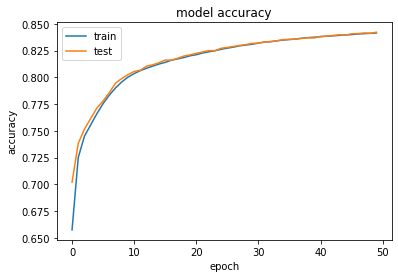

In [28]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

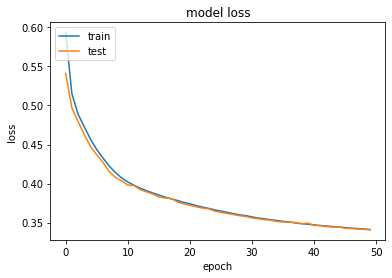

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
# evaluate the model
before_train_evaluation = datetime.datetime.now()
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
after_train_evaluation = datetime.datetime.now()
delta_train_evaluation = after_train_evaluation - before_train_evaluation
print("Model evaluation time on training data", delta_train_evaluation)

before_test_evaluation = datetime.datetime.now()
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
after_test_evaluation = datetime.datetime.now()
delta_test_evaluation = after_test_evaluation - before_test_evaluation
print("Model evaluation time on testing data", delta_test_evaluation)

print('Training Loss: %.3f, Testing loss: %.3f' % (train_loss, test_loss) )
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Model evaluation time on training data 0:04:13.736722
Model evaluation time on testing data 0:01:10.180504
Training Loss: 0.341, Testing loss: 0.344
Train: 0.842, Test: 0.840


In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

In [31]:
# Saving the model and loading the saved model

model.save('../diagram/New_GRU_PCA.h5')

# model.save('../saved_models/full_model_GRU_with_pca.h5')
#model = keras.models.load_model('../saved_models/gru_new.h5')

In [32]:
import gc
gc.collect()

92886

In [7]:
def predict(text_x):
    x = np.zeros((1, maxlen), dtype=np.int)
    offset = max(maxlen - len(text_x), 0)
    for t, char in enumerate(text_x):
        if t >= maxlen:
            break
        x[0, t + offset] = word_index[char]
    pred = model.predict(x)
    return pred[0][0]


# Like predict, but you pass in an array of URLs, and it is all
# vectorized in one step, making it more efficient
def predicts(text_X):
    X = np.zeros((len(text_X), maxlen), dtype=np.int)
    for i in range(len(text_X)):
        offset = max(maxlen - len(text_X[i]), 0)
        for t, char in enumerate(text_X[i]):
            if t >= maxlen:
                break
            X[i, t + offset] = word_index[char]
    preds = [pred[0] for pred in model.predict(X)]
    return preds

In [ ]:
import timeit

start = timeit.default_timer()
pre = predict(positives[0])
end = timeit.default_timer()
print("Prediction time", (end - start))

In [34]:
# Model Evaluation
# define a threshold value so that values below threshold will be classified as false_positive
threshold = 0.5

def evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold):
    false_negatives = 0.0
    preds = predicts(positives)
    for pred in preds:
        if pred <= threshold:
            false_negatives += 1
    print(false_negatives / len(positives), "false negatives for positives set.")

    false_positives_train = 0.0
    preds = predicts(negatives_train)
    for pred in preds:
        if pred > threshold:
            false_positives_train += 1

    false_positives_dev = 0.0
    preds = predicts(negatives_dev)
    for pred in preds:
        if pred > threshold:
            false_positives_dev += 1

    false_positives_test = 0.0
    preds = predicts(negatives_test)
    for pred in preds:
        if pred > threshold:
            false_positives_test += 1

    print(false_positives_train / len(negatives_train), "false positive rate for negative train.")
    print(false_positives_dev / len(negatives_dev), "false positive rate for negative dev.")
    print(false_positives_test / len(negatives_test), "false positive rate for negative test.")

evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold)

0.1787137417531643 false negatives for positives set.
0.13238350744195726 false positive rate for negative train.
0.13181194402067528 false positive rate for negative dev.
0.13268966862413184 false positive rate for negative test.


In [35]:
# Getting predictions on negative_dev set to find a suitable threshold value.

# defining the false positive rate which we can change.
fp_rate = 0.01

print("Getting threshold for fp_rate", fp_rate)
preds = predicts(negatives_dev)
preds.sort()
fp_index = math.ceil((len(negatives_dev) * (1 - fp_rate)))
threshold = preds[fp_index]

print("Using threshold", threshold) 

evaluate_model(positives, negatives_train, negatives_dev, negatives_test, threshold)

Getting threshold for fp_rate 0.01
Using threshold 0.9418243
0.47041667728467024 false negatives for positives set.
0.009601008689322121 false positive rate for negative train.
0.009989341915529457 false positive rate for negative dev.
0.009710699184273404 false positive rate for negative test.


### Bloom Filter 

In [8]:
##  Adapted from https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/ 

import math 
import mmh3 
from bitarray import bitarray 

class BloomFilter(object): 

    ''' 
    Class for Bloom filter, using murmur3 hash function 
    '''

    def __init__(self, items_count,fp_prob): 
        ''' 
        items_count : int 
            Number of items expected to be stored in bloom filter 
        fp_prob : float 
            False Positive probability in decimal 
        '''
        # False posible probability in decimal 
        self.fp_prob = fp_prob 

        # Size of bit array to use 
        self.size = self.get_size(items_count,fp_prob) 

        # number of hash functions to use 
        self.hash_count = self.get_hash_count(self.size,items_count) 

        # Bit array of given size 
        self.bit_array = bitarray(self.size) 
        
        # Return the size of bitarray in bytes
        self.byte_size = self.bit_array.length()

        # initialize all bits as 0 
        self.bit_array.setall(0) 

    def add(self, item): 
        ''' 
        Add an item in the filter 
        '''
        digests = [] 
        for i in range(self.hash_count): 

            # create digest for given item. 
            # i work as seed to mmh3.hash() function 
            # With different seed, digest created is different 
            digest = mmh3.hash(item,i) % self.size 
            digests.append(digest) 

            # set the bit True in bit_array 
            self.bit_array[digest] = True

    def check(self, item): 
        ''' 
        Check for existence of an item in filter 
        '''
        for i in range(self.hash_count): 
            digest = mmh3.hash(item,i) % self.size 
            if self.bit_array[digest] == False: 

                # if any of bit is False then,its not present 
                # in filter 
                # else there is probability that it exist 
                return False
        return True

    @classmethod
    def get_size(self,n,p): 
        ''' 
        Return the size of bit array(m) to used using 
        following formula 
        m = -(n * lg(p)) / (lg(2)^2) 
        n : int 
            number of items expected to be stored in filter 
        p : float 
            False Positive probability in decimal 
        '''
        m = -(n * math.log(p))/(math.log(2)**2) 
        return int(m)
    
    @classmethod
    def get_hash_count(self, m, n): 
        ''' 
        Return the hash function(k) to be used using 
        following formula 
        k = (m/n) * lg(2) 

        m : int 
			size of bit array 
		n : int 
			number of items expected to be stored in filter 
		'''
        k = (m/n) * math.log(2) 
        return int(k) 


### Defining Deep Bloom Model

In [9]:
# Defining the threshold value
fp_rate = 0.01
print("Getting threshold for fp_rate", fp_rate)
preds = predicts(negatives_dev)
preds.sort()
fp_index = math.ceil((len(negatives_dev) * (1 - fp_rate/2)))
threshold = preds[fp_index]
print("The threhold value to use is:", threshold)

Getting threshold for fp_rate 0.01
The threhold value to use is: 0.9733697


In [10]:
def create_bloom_filter(data):
    print("Creating bloom filter")
    false_negatives = []
    # calling the predicts function 
    preds = predicts(data)
    for i in range(len(data)):
        if preds[i] <= threshold:
            false_negatives.append(data[i])
    print("Number of false negatives at bloom time", len(false_negatives))
    bloom_filter = BloomFilter(len(false_negatives), fp_rate / 2)
    for fn in false_negatives:
        bloom_filter.add(fn)
    print("Created bloom filter")
    return bloom_filter

bloom_filter = create_bloom_filter(positives)

Creating bloom filter
Number of false negatives at bloom time 686033
Created bloom filter


In [11]:
# Function to predict the output from the machine learning model
def predict(text_x):
    x = np.zeros((1, maxlen), dtype=np.int)
    offset = max(maxlen - len(text_x), 0)
    for t, char in enumerate(text_x):
        if t >= maxlen:
            break
        x[0, t + offset] = word_index[char]
    pred = model.predict(x)
    return pred[0][0]


def check_item(item):
    if predict(item) > threshold:
        return True
    return bloom_filter.check(item)

#### Test Deep Bloom Model

In [12]:
print("Bloom filter bits needed", bloom_filter.size)
print("Bloom fiter size in bytes", (bloom_filter.byte_size)/8)
print("Hash functions needed", bloom_filter.hash_count)
    
false_positives = 0.0
print(len(negatives_test))
for neg in negatives_test:
    if check_item(neg):
        false_positives += 1
print("Test false positive rate: ", str(false_positives / len(negatives_test)))

Bloom filter bits needed 7565402
Bloom fiter size in bytes 945675.25
Hash functions needed 7
143553


KeyboardInterrupt: 